## Solving combinatorial optimization problems using QAOA


### Combinatorial Optimization Problem


In [23]:
import networkx as nx
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import XXPlusYYGate
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit import transpile
import numpy as np
import qiskit
import math

print(qiskit.__qiskit_version__)

#nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

{'qiskit-terra': '0.24.0', 'qiskit-aer': '0.12.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit': '0.43.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


In [24]:
# Grid/Graph creator
def QAOA_Graph_Creator(label="standard"):
    graph = nx.Graph()
    if label == "standard":
        graph.add_nodes_from([0, 1, 2, 3])
        graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (4,1),(4,2), (4,3)])
    elif label == "hardware":
        graph = nx.grid_2d_graph(3, 3)
    elif label == "Three-Regular":
        graph.add_nodes_from(range(8))  # This will add nodes 0 to 7
        graph.add_edges_from([(0, 1), (0, 2), (0, 3), 
                              (1, 4), (1, 5), 
                              (2, 6), (2, 7), 
                              (3, 4), (3, 7), 
                              (4, 6), 
                              (5, 6), (5, 7)])
    elif label == "SK": # SK = Sherrington-Kirkpatrick
        num_nodes = 7
        graph = nx.complete_graph(num_nodes)
    return graph


### The Problem Unitary (Hamiltonian)

In [25]:
"""
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw("mpl")
"""

'\ngamma = Parameter("$\\gamma$")\nqc_p = QuantumCircuit(N_QUBITS)\nfor pair in list(graph.edges()):  # pairs of nodes\n    qc_p.rzz(2 * gamma, pair[0], pair[1])\n    qc_p.barrier()\n\nqc_p.decompose().draw("mpl")\n'

In [26]:
# X-Mixer
def x_mixer(qc, n, b):
    for i in range(n):
        qc.rx(2 * b, i)
    return qc

# XY-Mixer
def xy_mixer_ring(qc, n, b):
    for i in range(n-1):
        qc.append(XXPlusYYGate(2*b, 0), [i, i+1])
    qc.append(XXPlusYYGate(2*b, 0), [0, n-1])
    return qc

# Full-Mixer
def xy_mixer_full(qc, n, b):
    for i in range(n):
        for j in range(i+1, n):
            qc.append(XXPlusYYGate(2 * b), [i, j])
    return qc
            
# Parity-Mixer
def xy_mixer_parity(qc, n, b):
    for i in range(n-1)[::2]:
        qc.append(XXPlusYYGate(2 * b), [i, i + 1])
    for i in range(n-1)[1::2]:
        qc.append(XXPlusYYGate(2 * b), [i, i + 1])
    return qc
    

### The Mixing Unitary (Hamiltonian)

In [27]:


# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
"""

adjacency = nx.adjacency_matrix(graph).todense()

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
qc_mix = xy_mixer_parity(qc_mix, N_QUBITS, beta)
qc_mix.draw("mpl")
"""

'\n\nadjacency = nx.adjacency_matrix(graph).todense()\n\nbeta = Parameter("$\\beta$")\nqc_mix = QuantumCircuit(N_QUBITS)\nqc_mix = xy_mixer_parity(qc_mix, N_QUBITS, beta)\nqc_mix.draw("mpl")\n'

## Initial State

In [28]:
"""
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw("mpl")
"""

'\nqc_0 = QuantumCircuit(N_QUBITS)\nfor i in range(N_QUBITS):\n    qc_0.h(i)\n\nqc_0.draw("mpl")\n'

### The QAOA circuit

In [29]:
"""

qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw()

qc_qaoa.decompose().draw("mpl")
"""

'\n\nqc_qaoa = QuantumCircuit(N_QUBITS)\nqc_qaoa.append(qc_0, range(N_QUBITS))\nqc_qaoa.append(qc_p, range(N_QUBITS))\nqc_qaoa.append(qc_mix, range(N_QUBITS))\n\nqc_qaoa.decompose().decompose().draw()\n\nqc_qaoa.decompose().draw("mpl")\n'

In [30]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        
        qc = xy_mixer_ring(qc, nqubits, beta[layer_index])

    qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        qc = transpile(qc, backend)
        counts = backend.run(qc, nshots=shots).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [31]:
from scipy.optimize import minimize

#N_QUBITS = 5
shots = 2048
graph = QAOA_Graph_Creator("SK")
expectation = get_expectation(graph, shots)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -10.50390625
       x: [ 9.792e-01  9.769e-01]
    nfev: 27
   maxcv: 0.0

        ┌───┐                                                                 »
   q_0: ┤ H ├─■────────────■────────────■─────────────────────────■───────────»
        ├───┤ │ZZ(1.9539)  │            │                         │           »
   q_1: ┤ H ├─■────────────┼────────────┼────────────■────────────┼───────────»
        ├───┤              │ZZ(1.9539)  │            │ZZ(1.9539)  │           »
   q_2: ┤ H ├──────────────■────────────┼────────────■────────────┼───────────»
        ├───┤                           │ZZ(1.9539)               │           »
   q_3: ┤ H ├───────────────────────────■─────────────────────────┼───────────»
        ├───┤                                                     │ZZ(1.9539) »
   q_4: ┤ H ├─────────────────────────────────────────────────────■───────────»
        ├───┤                                                                 »
   q_5: ┤ H ├─────────────────────────────────────────────────────────────────»
        ├───┤                           

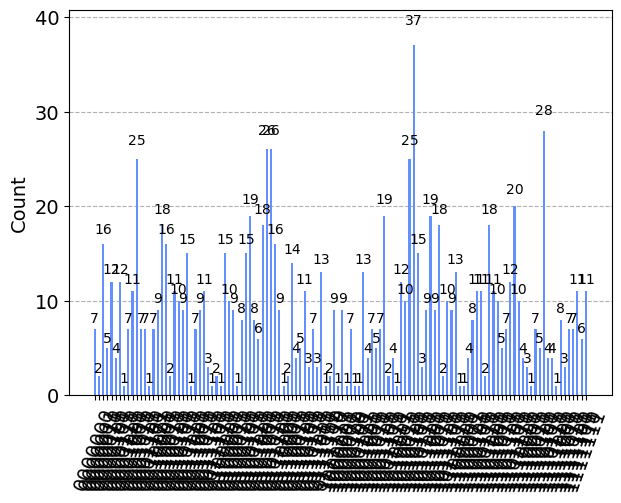

In [32]:
from qiskit import BasicAer
from qiskit.visualization import plot_histogram
from qiskit.execute_function import execute

backend = Aer.get_backend('aer_simulator')
backend.shots = shots

qc_res = create_qaoa_circ(graph, res.x)
print(qc_res.draw())

counts = execute(qc_res, backend).result().get_counts()
#counts = backend.run(qc_res, seed_simulator=5).result().get_counts()
plot_histogram(counts)



In [33]:
for key, val in counts.items():
    if(val>=80):
        print(str(key)+" "+str(val))

In [34]:
#xmixer
#01011 110
#10100 100
#xy mixer ring
#11010 103
#01010 145
#10101 135

#xy full
#10101 148
#00001 142
#01010 167
#11110 157

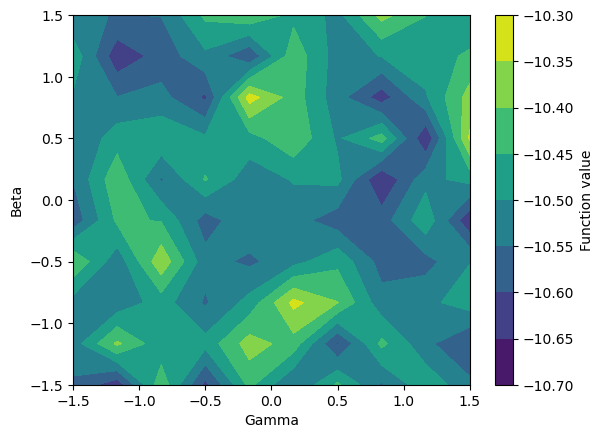

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from math import pi

# Define the range of gamma and beta values
gamma_values = np.linspace(-1.5, 1.5, 10)
beta_values = np.linspace(-1.5, 1.5, 10)

# Initialize an array to store the function values
fun_values = np.zeros((len(gamma_values), len(beta_values)))

# Run the QAOA circuit for each pair of gamma and beta values
for i, gamma in enumerate(gamma_values):
    for j, beta in enumerate(beta_values):
        theta = [beta, gamma]
        expectation = get_expectation(graph, shots)
        res = minimize(expectation, theta, method='COBYLA')
        fun_values[i, j] = res.fun

# Create the contour plot
plt.contourf(gamma_values, beta_values, fun_values)
plt.colorbar(label='Function value')
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.show()
